In [35]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchmetrics import Metric
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy
import logging
import os
logging.getLogger("lightning").addHandler(logging.NullHandler())
logging.getLogger("lightning").propagate = False
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
import random


seed = 42

In [36]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [37]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    
    global x_scaler
    global y_scaler
    
    #x_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [92]:
class History:
    def __init__(self):
        self.history = {}


class LinearLearningRateScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_init, lr_final, epochs, last_epoch=-1):
        self.lr_init = lr_init
        self.lr_final = lr_final
        self.epochs = epochs
        super().__init__(optimizer, last_epoch=last_epoch)
    
    def step(self):
        self.last_epoch += 1
        epoch = self.last_epoch
        if epoch < self.epochs:
            alpha = epoch / self.epochs
            lr = self.lr_init * (1 - alpha) + alpha*self.lr_final
        else:
            lr = self.lr_final
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
    

def get_activation_function(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "linear":
        return None

def mee(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).sqrt().mean()

def mse(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).mean()


class TestCallback(pl.Callback):
    
    def __init__(self, x_test, y_test, task):
        self.x_test = x_test
        self.y_test = y_test
        self.task = task
    
    def on_train_epoch_end(self, trainer, model):
        
        y_pred = model(torch.from_numpy(self.x_test).to(torch.float32))
        y_test = torch.from_numpy(self.y_test)
        
        if self.task == "classification":
            loss = model.compute_loss(y_pred, y_test)
            acc = model.compute_metric(y_pred, y_test)
            model.log_dict({'test_loss': loss, 'test_accuracy': acc}, prog_bar=True, logger=True)
        elif self.task == "regression":
            loss = model.compute_loss(y_pred, y_test)
            test_mee = model.compute_metric(y_pred, y_test)
            model.log_dict({'test_loss': loss, 'test_mee': test_mee}, prog_bar=True, logger=True)
        
        
    
    
class MEE(Metric):
    
    def __init__(self):
        super().__init__()
        self.add_state("result", default=torch.tensor(0.0))
        
    def update(self, y_pred, y_true):
        self.result += mee(y_true, y_pred)

    def compute(self):
        return self.result
    

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_dim, output_dim, config):
        super(MultiLayerPerceptron, self).__init__()
        
        task = config["task"]
        self.lr = config["learning_rate"]
        self.momentum = config["momentum"]
        self.nesterov = config["nesterov"]
        init = config["initialization"]
        reg_method = config["regularization"]["method"]
        self.reg_method = reg_method
        self.lr_decay = config["learning_rate_decay"]        
        
        
        if reg_method != None:
            value = config["regularization"]["value"]
            self.reg_value = value
        
        self.task = task
        self.model = nn.Sequential()
                
        units = config["units_1"]
        activation = get_activation_function(config["activations_1"])
        
        self.model.add_module("linear_input", nn.Linear(input_dim, units))
        self.model.add_module("activations_1", activation)
        
        n_layers = 0
        for key in config.keys():
            if key.startswith("units_"):
                n_layers += 1
                
        for n_layer in range(2, n_layers+1):
            out_units = config[f"units_{n_layer}"]
            self.model.add_module(f"linear_{n_layer}", nn.Linear(units, out_units))
            activation = get_activation_function(config[f"activations_{n_layer}"])
            if activation != None:
                self.model.add_module(f"activations_{n_layer}", activation)
            units = out_units
        
        if task == "classification":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.model.add_module("activations_output", nn.Sigmoid())
            self.metric = Accuracy()
            self.metric_name = "accuracy"
        
        if task == "regression":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.metric = MEE()
            self.metric_name = "mee"
            
            
        self.loss = nn.MSELoss()
        self.dicts = []
                    
        if init["type"] == "uniform":
            self.min = init["min"]
            self.max = init["max"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.uniform_(param, self.min, self.max)
                if 'bias' in name:
                    nn.init.uniform_(param, self.min, self.max)

            
        elif init["type"] == "normal":
            self.mean = init["mean"]
            self.std = init["std"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.normal_(param, self.mean, self.std)
                if 'bias' in name:
                    nn.init.normal_(param, self.mean, self.std)
            
            

    def init_weights_uniform(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight, self.min, self.max)
            torch.nn.init.uniform_(m.bias, self.min, self.max)
            # m.bias.data.fill_(0.01)
        
            

    def init_weights_normal(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, self.mean, self.std)
            torch.nn.init.normal_(m.bias, self.mean, self.std)
            # m.bias.data.fill_(0.01)
            
            
    def compute_metric(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.metric(y_pred, y_true.to(torch.int32))
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.metric(y_pred, y_true)


    def compute_loss(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.loss(y_pred, y_true)
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.loss(y_pred, y_true)
        
        
    def get_regularization_term(self):
        
        if self.reg_method != None:
            
            value = self.reg_value
            p = 1 if self.reg_method == "l1" else 2
            reg = 0
            
            for param in self.model.parameters():
                reg += torch.linalg.norm(param, p)
                
            reg *= value
            
            return reg
        
        return 0
            
        
        
    def forward(self, x):
        return self.model(x)

    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, nesterov=self.nesterov)
        if self.lr_decay != None:
            decay_epochs = self.lr_decay["epochs"]
            lr_final = self.lr_decay["lr_final"]
            lr_init = self.lr
            scheduler = LinearLearningRateScheduler(optimizer, lr_init, lr_final, decay_epochs)
            return [optimizer], [scheduler]
            
        return optimizer
    
    
    

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X)
        # accuracy
        acc = self.compute_metric(y_pred, y_copy)
        # compute loss
        reg = self.get_regularization_term()
        loss = self.compute_loss(y_pred, y) + reg
        self.log_dict({'loss': loss, f'{self.metric_name}': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'val_loss': loss, f'val_{self.metric_name}': acc}, prog_bar=True, logger=True)
        return loss
    
    
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        # self.log_dict({'test_loss': loss, f'test_{self.metric_name}': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss

    
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [93]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged

def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    early_stopping = config["early_stopping"]
    callbacks = []
    
    if early_stopping != None:        
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"],
            min_delta=early_stopping["delta"],
            patience=early_stopping["patience"], 
            verbose=False,
            mode="min"
        )
        
        callbacks.append(early_stop)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged


def get_model(config, input_size, output_size):
    model = MultiLayerPerceptron(input_size, output_size, config)
    return model
    
    
    
def fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, metric, config, x_test=None, y_test=None):  
    
    if batch_size is None:
        batch_size_train = x_train.shape[0]
        batch_size_val = x_val.shape[0]
    else:
        batch_size_train = batch_size
        batch_size_val = batch_size
        
    
    
    train_loader = DataLoader(dataset = CustomDataset(x_train, y_train), batch_size=batch_size_train)
    validation_loader = DataLoader(dataset = CustomDataset(x_val, y_val), batch_size=batch_size_val)
    
    callbacks = get_callbacks(config)

    if x_test is not None:
        callbacks.append(TestCallback(x_test, y_test, config["task"]))
        
    trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,
                         log_every_n_steps=1, logger=CSVLogger(save_dir="logs/"),
                         callbacks=callbacks, enable_progress_bar=False,
                         enable_model_summary=False
                        )  
    
    
    trainer.fit(model=model, train_dataloaders=train_loader,
                val_dataloaders=validation_loader) 
    
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    

    history = History()
                
    history.history["loss"] = metrics["loss"].dropna().to_list()
    history.history["val_loss"] = metrics["val_loss"].dropna().to_list()
    history.history[f"{metric}"] = metrics[f"{metric}"].dropna().to_list()
    history.history[f"val_{metric}"] = metrics[f"val_{metric}"].dropna().to_list()
    
    if x_test is not None:
        history.history["test_loss"] = metrics["test_loss"].dropna().to_list()
        history.history[f"test_{metric}"] = metrics[f"test_{metric}"].dropna().to_list() 
    
    return history
    
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    kf = StratifiedKFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]
        
        # print(y_val_fold.shape)
        # print(y_val_fold)

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                
                
                
                model = get_model(config, input_size, output_size)
                history = fit(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, 
                              max_epochs, batch_size, train_metric, config)
                
                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the mean metrics among the trials
        # med_idx = median_index(trials_val_loss)
        # med_val_loss = trials_val_loss[med_idx]
        # med_train_loss = trials_train_loss[med_idx]
        # med_val_acc = trials_val_acc[med_idx]
        # med_train_acc = trials_train_acc[med_idx]
        med_val_loss = np.mean(trials_val_loss)
        med_train_loss = np.mean(trials_train_loss)
        med_val_acc = np.mean(trials_val_acc)
        med_train_acc = np.mean(trials_train_acc)
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} mean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)  

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
                                    
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_val_loss = np.mean(trials_val_loss)
    med_train_loss = np.mean(trials_train_loss)
    med_val_acc = np.mean(trials_val_acc)
    med_train_acc = np.mean(trials_train_acc)
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"\nMean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, x_test, y_test, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
        test_metric = "test_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        test_metric = "test_mee"
    val_loss = "val_mse"
    train_loss = "mse"
    test_loss = "test_mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    trials_test_acc = []
    trials_test_loss = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []
    trials_history_test_acc = []
    trials_history_test_loss = [] 
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            torch.save(model, f"./../models/pytorch_model_{trial}.pt")
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config, x_test, y_test)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]
            trial_test_loss = history.history["test_loss"]
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            trial_test_acc = history.history[test_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_test_loss.append(trial_test_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            trials_test_acc.append(trial_test_acc[-1])
            

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_test_loss.append(trial_test_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)
            trials_history_test_acc.append(trial_test_acc)
            

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            # print(f"Trial {trial+1}/{trials} {test_loss}: {trial_test_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")
            # print(f"Trial {trial+1}/{trials} {test_metric}: {trial_test_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    test_acc = trials_history_test_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    
    train_loss = trials_history_train_loss[med_idx]
    test_loss = trials_history_test_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    
    
    print(f"\nMedian model train_loss: {train_loss[-1]}")
    print(f"Median model val_loss: {val_loss[-1]}")
    print(f"Median model test_loss: {test_loss[-1]}")
    
    print(f"\nMedian model train_{train_metric}: {train_acc[-1]}")
    print(f"Median model {val_metric}: {val_acc[-1]}")
    print(f"Median model {test_metric}: {test_acc[-1]}")
    
    
    plot_curves(train_acc, f"Training {train_metric}", test_acc, f"Test {train_metric}")
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {val_metric}")
    
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    
    if task == "regression":
        
        y_pred = model(torch.from_numpy(x_val).to(torch.float32))
        # y_val = y_val.detach().numpy()
        
        y_pred = y_scaler.inverse_transform(y_pred.detach().numpy())
        y_val  = y_scaler.inverse_transform(y_val)
        
        y_pred  = torch.from_numpy(y_pred).to(torch.float32)
        y_val  = torch.from_numpy(y_val).to(torch.float32)
        
        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
    
    
    for trial in range(trials):
        if trial != med_idx:
            os.system(f"rm ./../models/pytorch_model_{trial}.pt")
            
    os.system(f"mv ./../models/pytorch_model_{med_idx}.pt ./../models/pytorch_model.pt")
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    
    y_pred = model(torch.from_numpy(x_test).to(torch.float32))
    y_test = torch.from_numpy(y_test).to(torch.float32)
    
    acc = model.compute_metric(y_pred, y_test)
    loss = model.compute_loss(y_pred, y_test)
    
    print(f"Test MSE: {loss}")
    print(f"Test accuracy: {acc}")
    
    #test_loader = DataLoader(dataset = CustomDataset(x_test, y_test), batch_size=batch_size)
    #trainer.test(model=model, dataloaders=test_loader)
    #input_size = x_test.shape[1]
    #result = model.evaluate(x_test, y_test)
    #print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model(torch.from_numpy(x_train).to(torch.float32))
    y_test_pred = model(torch.from_numpy(x_test).to(torch.float32))
    
    if scale:
        
        y_train_pred = y_train_pred.detach().numpy()
        y_test_pred = y_test_pred.detach().numpy()
        
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)
        
        y_train_pred  = torch.from_numpy(y_train_pred).to(torch.float32)
        y_test_pred  = torch.from_numpy(y_test_pred).to(torch.float32)
        
    y_train = torch.from_numpy(y_train).to(torch.float32)
    y_test = torch.from_numpy(y_test).to(torch.float32)
    

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:
        
        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, x_test, y_test, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, x_test, y_test, best_conf)
    
    return model

# Monk 1

In [94]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [97]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.2, 0.3],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.7, 0.8, 0.9],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/9:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.70s/it]


Fold 1/4 mean val_loss: 0.1603363965784988, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0871329456567764, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8064516186714172, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9032257795333862, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.66s/it]


Fold 2/4 mean val_loss: 0.0657788148940332, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0227350424975156, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9892473220825196, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Fold 3/4 mean val_loss: 0.0628596740885872, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0236961115151643, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.07s/it]


Fold 4/4 mean val_loss: 0.1250792317180593, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0430852100253105, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9892473220825196, train_accuracy 0.0

Mean val_loss: 0.10351352931979461, std val_loss: 0.04114171356842278
Mean train_loss: 0.044162327423691694, std train_loss: 0.026103777246527946
Mean val_accuracy: 0.8870967626571655, std val_accuracy: 0.058154038698423546
Mean train_accuracy: 0.8870967626571655, std train_accuracy: 0.03904796847851022



Testing configuration 2/9:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.88s/it]


Fold 1/4 mean val_loss: 0.0412993188856187, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0250745825469493, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.85s/it]


Fold 2/4 mean val_loss: 0.0401985661752983, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0144847081974148, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Fold 3/4 mean val_loss: 0.1982645439904622, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1030299663543701, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.7096773982048035, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.8924731016159058, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


Fold 4/4 mean val_loss: 0.1796809831810195, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1351765245199203, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.6451612710952759, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.8279569745063782, train_accuracy 0.0

Mean val_loss: 0.11486085305809968, std val_loss: 0.07440359756535993
Mean train_loss: 0.06944144540466363, std train_loss: 0.05108314509253459
Mean val_accuracy: 0.8225806206464767, std val_accuracy: 0.1469424727037455
Mean train_accuracy: 0.8225806206464767, std train_accuracy: 0.07352040688280763



Testing configuration 3/9:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}



100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.00s/it]


Fold 1/4 mean val_loss: 0.0030710226676031, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0016531262081116, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.96s/it]


Fold 2/4 mean val_loss: 0.0204404851367815, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0022882421035319, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.15s/it]


Fold 3/4 mean val_loss: 0.0148395017024218, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0041621415875852, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.96s/it]


Fold 4/4 mean val_loss: 0.0249924916445073, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0023629358038306, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.015835875287828427, std val_loss: 0.00820030910548871
Mean train_loss: 0.002616611425764825, std train_loss: 0.0009339626569997626
Mean val_accuracy: 0.9838709533214569, std val_accuracy: 0.01612904667854309
Mean train_accuracy: 0.9838709533214569, std train_accuracy: 0.0



Testing configuration 4/9:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.52s/it]


Fold 1/4 mean val_loss: 0.0273756334117128, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0045661670155823, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.80s/it]


Fold 2/4 mean val_loss: 0.1029551347728991, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0063617723062634, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.69s/it]


Fold 3/4 mean val_loss: 0.0153703406006655, std val_loss 0.0
Fold 3/4 mean train_loss: 0.003942095208913, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Fold 4/4 mean val_loss: 0.2345163672626177, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1210229396820068, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.6774193644523621, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.8602150678634644, train_accuracy 0.0

Mean val_loss: 0.09505436901197378, std val_loss: 0.08723821796090267
Mean train_loss: 0.033973243553191375, std train_loss: 0.050266014766201336
Mean val_accuracy: 0.8870967626571655, std val_accuracy: 0.12597175948829129
Mean train_accuracy: 0.8870967626571655, std train_accuracy: 0.060528651148261815



Testing configuration 5/9:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.78s/it]


Fold 1/4 mean val_loss: 0.0285824729045909, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0019428484374657, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.79s/it]


Fold 2/4 mean val_loss: 0.0524020320300052, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0034532556310296, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.73s/it]


Fold 3/4 mean val_loss: 0.002146144204956, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0015005549648776, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.98s/it]


Fold 4/4 mean val_loss: 0.0688087318946937, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0023784830700606, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.03798484525856145, std val_loss: 0.025153450860926796
Mean train_loss: 0.002318785525858375, std train_loss: 0.0007248131072323166
Mean val_accuracy: 0.9596774131059647, std val_accuracy: 0.026746971072215853
Mean train_accuracy: 0.9596774131059647, std train_accuracy: 0.0



Testing configuration 6/9:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.92s/it]


Fold 1/4 mean val_loss: 0.0028913779058996, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0009958524024114, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


Fold 2/4 mean val_loss: 0.138454913079025, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1136643067002296, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8064516186714172, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.8817204236984253, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.04s/it]


Fold 3/4 mean val_loss: 0.04079426625315, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0011230105301365, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.73s/it]


Fold 4/4 mean val_loss: 0.0044097509679069, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0004555449704639, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.04663757705149538, std val_loss: 0.05513956544920868
Mean train_loss: 0.029059678650810352, std train_loss: 0.04884714761469883
Mean val_accuracy: 0.9354838728904724, std val_accuracy: 0.07901579579944178
Mean train_accuracy: 0.9354838728904724, std train_accuracy: 0.05121655891301178



Testing configuration 7/9:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


Fold 1/4 mean val_loss: 0.2237357985763842, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1025391966104507, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.7096773982048035, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9139785170555116, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.59s/it]


Fold 2/4 mean val_loss: 0.0052929229472697, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0024754663463681, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.90s/it]


Fold 3/4 mean val_loss: 0.0132785948561124, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0026172921061515, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Fold 4/4 mean val_loss: 0.1635685259914515, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0977672860026359, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.774193525314331, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9032257795333862, train_accuracy 0.0

Mean val_loss: 0.10146896059280446, std val_loss: 0.09464790874495142
Mean train_loss: 0.05134981026640155, std train_loss: 0.04883260987254583
Mean val_accuracy: 0.8709677308797836, std val_accuracy: 0.13103288826269355
Mean train_accuracy: 0.8709677308797836, std train_accuracy: 0.045856782427738454



Testing configuration 8/9:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.77s/it]


Fold 1/4 mean val_loss: 0.0266585184214018, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0012514976551756, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Fold 2/4 mean val_loss: 0.1383490389081351, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0720588639378547, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9354838728904724, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.67s/it]


Fold 3/4 mean val_loss: 0.008405863539694, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0007958816713653, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.22s/it]


Fold 4/4 mean val_loss: 0.002100298327849, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0008317941101267, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.04387842979926997, std val_loss: 0.05528321752472663
Mean train_loss: 0.018734509343630572, std train_loss: 0.030787351567182982
Mean val_accuracy: 0.9677419364452362, std val_accuracy: 0.0558726050306368
Mean train_accuracy: 0.9677419364452362, std train_accuracy: 0.0279363025153184



Testing configuration 9/9:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.38s/it]


Fold 1/4 mean val_loss: 0.0060113080017278, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0003822882135864, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Fold 2/4 mean val_loss: 0.2732885672088929, std val_loss 0.0
Fold 2/4 mean train_loss: 0.1237165257334709, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.6451612710952759, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.8602150678634644, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


Fold 3/4 mean val_loss: 0.1801761845180743, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0773262754082679, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.7419354915618896, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9139785170555116, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.04s/it]


Fold 4/4 mean val_loss: 0.0062260353282313, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0003773306962102, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.11642552376423157, std val_loss: 0.1151144945687533
Mean train_loss: 0.050450605012883856, std train_loss: 0.05268862767747972
Mean val_accuracy: 0.8467741906642914, std val_accuracy: 0.15699937854955995
Mean train_accuracy: 0.8467741906642914, std train_accuracy: 0.05956590574197805






Best configuration (loss 0.015835875287828427):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:15<02:18, 15.39s/it]

Trial 1/10 val_mse: 0.0019678140888821
Trial 1/10 train_mse: 0.0015016673132777
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:18<01:04,  8.07s/it]

Trial 2/10 val_mse: 0.0689767881829167
Trial 2/10 train_mse: 0.0956077426671981
Trial 2/10 val_accuracy: 0.9230769276618958
Trial 2/10 train_accuracy: 0.8828828930854797


 30%|█████████████▏                              | 3/10 [00:21<00:39,  5.65s/it]

Trial 3/10 val_mse: 0.0773949704360932
Trial 3/10 train_mse: 0.1042229011654853
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 0.8828828930854797


 40%|█████████████████▌                          | 4/10 [00:32<00:48,  8.09s/it]

Trial 4/10 val_mse: 0.0010916917811471
Trial 4/10 train_mse: 0.0015620595077052
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [00:43<00:44,  8.86s/it]

Trial 5/10 val_mse: 0.0060188593630256
Trial 5/10 train_mse: 0.0029727816581726
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [00:54<00:39,  9.80s/it]

Trial 6/10 val_mse: 0.0016389829270923
Trial 6/10 train_mse: 0.0011676383437588
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [01:05<00:30, 10.10s/it]

Trial 7/10 val_mse: 0.0028323259597242
Trial 7/10 train_mse: 0.0018261093646287
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [01:17<00:21, 10.63s/it]

Trial 8/10 val_mse: 0.0006490098201391
Trial 8/10 train_mse: 0.0018549733795225
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:27<00:10, 10.59s/it]

Trial 9/10 val_mse: 0.001464771954791
Trial 9/10 train_mse: 0.0024900373537093
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [01:31<00:00,  9.11s/it]

Trial 10/10 val_mse: 0.0692203247710359
Trial 10/10 train_mse: 0.0866957306861877
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 0.8918918967247009

Median val_mse: 0.0028323259597242, std val_mse: 0.03200919482042425
Median train_mse: 0.0018261093646287, std train_mse: 0.04307339733878422
Median val_accuracy: 1.0, std val_accuracy: 0.023076921701431274
Median train_accuracy: 1.0, std train_accuracy: 0.052345362019762795

Median model train_loss: 0.0018261093646287
Median model val_loss: 0.0028323259597242
Median model test_loss: 0.002290882594721

Median model accuracy: 1.0
Median model val_accuracy: 1.0
Median model test_accuracy: 1.0


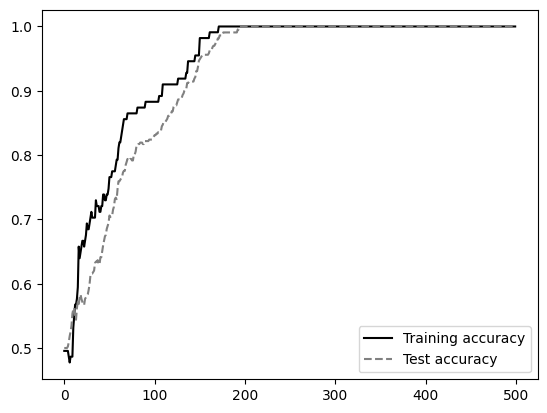

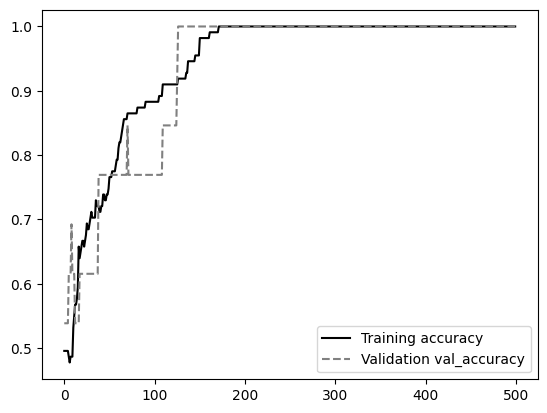

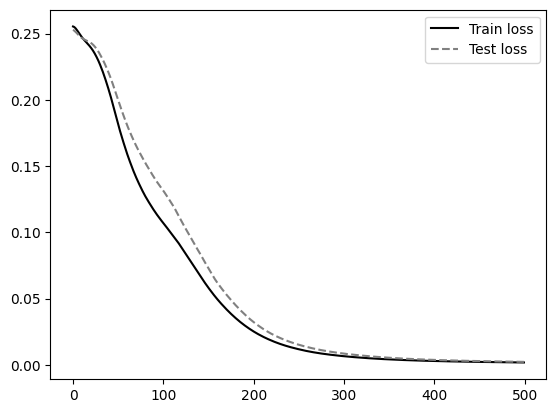

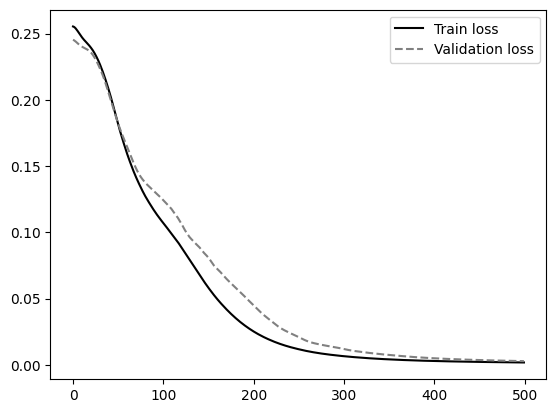

In [98]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
# test_model(model, x_test, y_test)

# Monk 2

In [99]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [100]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.5, 0.8],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.1, 0.5, 0.8],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.5, 0.6, 0.7],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.5, 0.6, 0.7],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/9:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


Fold 1/4 mean val_loss: 0.2452756509470402, std val_loss 0.0
Fold 1/4 mean train_loss: 0.2235573679208755, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.5581395626068115, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.6349206566810608, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.03s/it]


Fold 2/4 mean val_loss: 0.0026785491208826, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0016814041882753, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.11s/it]


Fold 3/4 mean val_loss: 0.0031656063978604, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0013073293957859, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.59s/it]


Fold 4/4 mean val_loss: 0.0014071682939391, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0012380168773233, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.06313174368993059, std val_loss: 0.10516279346094388
Mean train_loss: 0.056946029595565, std train_loss: 0.09619324888069823
Mean val_accuracy: 0.8895348906517029, std val_accuracy: 0.19133118185490236
Mean train_accuracy: 0.8895348906517029, std train_accuracy: 0.158083992855571



Testing configuration 2/9:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.34s/it]


Fold 1/4 mean val_loss: 0.0009409584523643, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0008345187525264, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.26s/it]


Fold 2/4 mean val_loss: 0.0013091688767886, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0009530319366604, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.17s/it]


Fold 3/4 mean val_loss: 0.0015367818871605, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0010270723141729, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.61s/it]


Fold 4/4 mean val_loss: 0.0016130172807578, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0010242622811347, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0013499816242678, std val_loss: 0.0002612698462857455
Mean train_loss: 0.0009597213211236, std train_loss: 7.813789546646732e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 3/9:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Fold 1/4 mean val_loss: 0.2359302872343453, std val_loss 0.0
Fold 1/4 mean train_loss: 0.2336685210466385, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.6279069781303406, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.6190476417541504, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.67s/it]


Fold 2/4 mean val_loss: 0.001009130227168, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0007186521543189, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.60s/it]


Fold 3/4 mean val_loss: 0.000988267745375, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0006240953807719, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Fold 4/4 mean val_loss: 0.2508561022662058, std val_loss 0.0
Fold 4/4 mean train_loss: 0.2139953523874282, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.6190476417541504, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.6771653294563293, train_accuracy 0.0

Mean val_loss: 0.12219594686827354, std val_loss: 0.12131207871795992
Mean train_loss: 0.11225165524228937, std train_loss: 0.11179686725146969
Mean val_accuracy: 0.8117386549711227, std val_accuracy: 0.18828740003571742
Mean train_accuracy: 0.8117386549711227, std train_accuracy: 0.1771425120383439



Testing configuration 4/9:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}



100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.03s/it]


Fold 1/4 mean val_loss: 0.0012149565371124, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0008832671446725, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.91s/it]


Fold 2/4 mean val_loss: 0.0011779606579817, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0011856070486828, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Fold 3/4 mean val_loss: 0.2490257267694276, std val_loss 0.0
Fold 3/4 mean train_loss: 0.2084905207157135, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.5714285969734192, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.6062992215156555, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.98s/it]


Fold 4/4 mean val_loss: 0.0018014237965287, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0012629008851945, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0633050169402626, std val_loss: 0.10722618704426568
Mean train_loss: 0.05295557394856583, std train_loss: 0.0897982554437861
Mean val_accuracy: 0.8928571492433548, std val_accuracy: 0.185576861178279
Mean train_accuracy: 0.8928571492433548, std train_accuracy: 0.17047743782857613



Testing configuration 5/9:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Fold 1/4 mean val_loss: 0.245489130011659, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1943358331918716, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.4883720874786377, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.6666666865348816, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.14s/it]


Fold 2/4 mean val_loss: 0.048979743309701, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0026742119807749, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9523809552192688, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 3/4 mean val_loss: 0.2454551283784072, std val_loss 0.0
Fold 3/4 mean train_loss: 0.2206602841615677, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.6190476417541504, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.6299212574958801, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


Fold 4/4 mean val_loss: 0.239242036495893, std val_loss 0.0
Fold 4/4 mean train_loss: 0.2318078726530075, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.6190476417541504, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.6220472455024719, train_accuracy 0.0

Mean val_loss: 0.19479150954891505, std val_loss: 0.0842228762171355
Mean train_loss: 0.1623695504968054, std train_loss: 0.09319862470569942
Mean val_accuracy: 0.6697120815515518, std val_accuracy: 0.17169715818186196
Mean train_accuracy: 0.6697120815515518, std train_accuracy: 0.1569874157555136



Testing configuration 6/9:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Exe

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.64s/it]


Fold 1/4 mean val_loss: 0.000725206576983, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0004575584316626, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Fold 2/4 mean val_loss: 0.2441794592731145, std val_loss 0.0
Fold 2/4 mean train_loss: 0.217819333076477, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.6190476417541504, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.6220472455024719, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.81s/it]


Fold 3/4 mean val_loss: 0.0026024385925381, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0005398016073741, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.02s/it]


Fold 4/4 mean val_loss: 0.0006256346727348, std val_loss 0.0
Fold 4/4 mean train_loss: 0.000469939172035, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.06203318477884259, std val_loss: 0.10516514905808556
Mean train_loss: 0.05482165807188717, std train_loss: 0.09410675676485283
Mean val_accuracy: 0.9047619104385376, std val_accuracy: 0.16495720993624802
Mean train_accuracy: 0.9047619104385376, std train_accuracy: 0.1636583434125813



Testing configuration 7/9:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.84s/it]


Fold 1/4 mean val_loss: 0.0020010266705491, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0007927062688395, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Fold 2/4 mean val_loss: 0.2385270500409256, std val_loss 0.0
Fold 2/4 mean train_loss: 0.2173072397708892, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.6190476417541504, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.6220472455024719, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Fold 3/4 mean val_loss: 0.2374952433505833, std val_loss 0.0
Fold 3/4 mean train_loss: 0.2246798276901245, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.6190476417541504, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.6220472455024719, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.15s/it]


Fold 4/4 mean val_loss: 0.0010780496544516, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0007739075808785, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.1197753424291274, std val_loss: 0.11823681733930617
Mean train_loss: 0.11088842032768292, std train_loss: 0.11013596335076435
Mean val_accuracy: 0.8095238208770752, std val_accuracy: 0.1904761791229248
Mean train_accuracy: 0.8095238208770752, std train_accuracy: 0.18897637724876404



Testing configuration 8/9:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.19s/it]


Fold 1/4 mean val_loss: 0.0008407685724898, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0005840797675773, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Fold 2/4 mean val_loss: 0.2365037413604141, std val_loss 0.0
Fold 2/4 mean train_loss: 0.2179145812988281, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.5952380895614624, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.6614173054695129, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.86s/it]


Fold 3/4 mean val_loss: 0.0018628710752276, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0006117055891081, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Fold 4/4 mean val_loss: 0.239503840583586, std val_loss 0.0
Fold 4/4 mean train_loss: 0.2181412279605865, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.5952380895614624, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.6692913174629211, train_accuracy 0.0

Mean val_loss: 0.11967780539792938, std val_loss: 0.11833129139489924
Mean train_loss: 0.10931289865402499, std train_loss: 0.10871503594618158
Mean val_accuracy: 0.7976190447807312, std val_accuracy: 0.2023809552192688
Mean train_accuracy: 0.7976190447807312, std train_accuracy: 0.16734600151085613



Testing configuration 9/9:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

E

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.20s/it]


Fold 1/4 mean val_loss: 0.0004143415897796, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0003384893643669, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.85s/it]


Fold 2/4 mean val_loss: 0.0004216702478459, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0003465162299107, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.22s/it]


Fold 3/4 mean val_loss: 0.0019825324669439, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0009791533229872, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.86s/it]


Fold 4/4 mean val_loss: 0.0005056945384578, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0003767925081774, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0008310597107568001, std val_loss: 0.0006657713061328789
Mean train_loss: 0.00051023785636055, std train_loss: 0.00027110500330263556
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0






Best configuration (loss 0.0008310597107568001):
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:10<01:31, 10.13s/it]

Trial 1/10 val_mse: 0.0003682882809139
Trial 1/10 train_mse: 0.0003349363687448
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:19<01:18,  9.79s/it]

Trial 2/10 val_mse: 0.0003668373443289
Trial 2/10 train_mse: 0.0003504838387016
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:29<01:08,  9.82s/it]

Trial 3/10 val_mse: 0.0015471096045612
Trial 3/10 train_mse: 0.0010006151860579
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:39<00:59,  9.88s/it]

Trial 4/10 val_mse: 0.0003996218951009
Trial 4/10 train_mse: 0.0003471625386737
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [00:50<00:50, 10.14s/it]

Trial 5/10 val_mse: 0.0004223579241626
Trial 5/10 train_mse: 0.0003566810628399
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [01:00<00:41, 10.37s/it]

Trial 6/10 val_mse: 0.0014168412639539
Trial 6/10 train_mse: 0.0005826361011713
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [01:01<00:21,  7.15s/it]

Trial 7/10 val_mse: 0.232653385610534
Trial 7/10 train_mse: 0.2187579870223999
Trial 7/10 val_accuracy: 0.529411792755127
Trial 7/10 train_accuracy: 0.6052631735801697


 80%|███████████████████████████████████▏        | 8/10 [01:12<00:16,  8.36s/it]

Trial 8/10 val_mse: 0.0014830442614177
Trial 8/10 train_mse: 0.00096029631095
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:22<00:08,  8.80s/it]

Trial 9/10 val_mse: 0.0003733611912853
Trial 9/10 train_mse: 0.0003503503685351
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [01:32<00:00,  9.27s/it]

Trial 10/10 val_mse: 0.0006041087990275
Trial 10/10 train_mse: 0.0003957667504437
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median val_mse: 0.0006041087990275, std val_mse: 0.06956494782381298
Median train_mse: 0.0003957667504437, std train_mse: 0.06547188432364946
Median val_accuracy: 1.0, std val_accuracy: 0.14117646217346191
Median train_accuracy: 1.0, std train_accuracy: 0.1184210479259491

Median model train_loss: 0.0003957667504437
Median model val_loss: 0.0006041087990275
Median model test_loss: 0.0007296626360649

Median model accuracy: 1.0
Median model val_accuracy: 1.0
Median model test_accuracy: 1.0


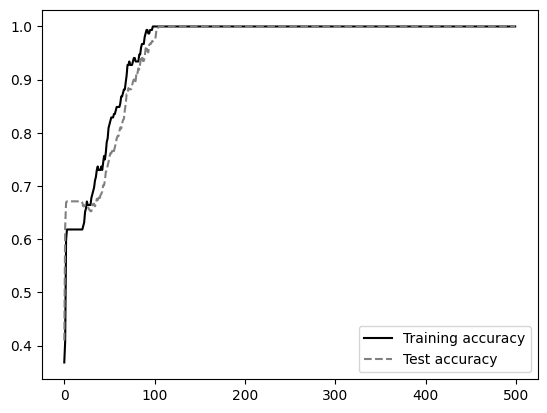

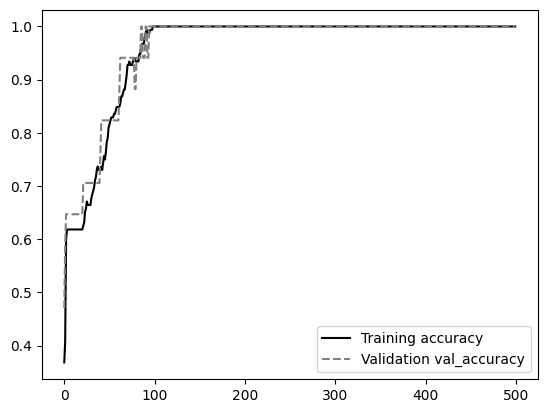

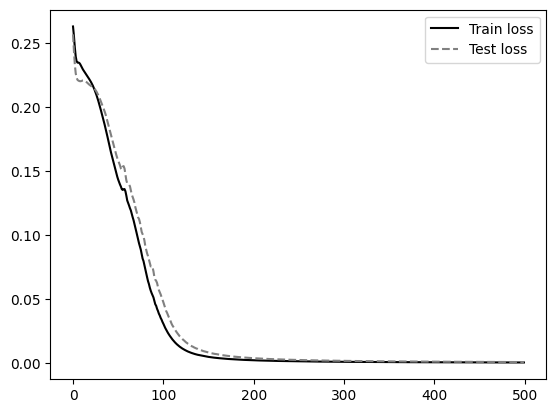

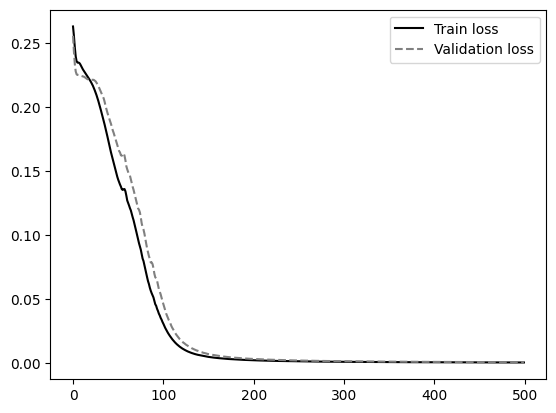

In [101]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
# test_model(model, x_test, y_test)

# Monk 3

In [105]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


In [106]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.2, 0.3],
    "batch_size": [None],
    "momentum": [0.7, 0.8, 0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": "l1",
            "value": [0.01, 0.001]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [16],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.2
}


Testing configuration 1/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.36s/it]


Fold 1/4 mean val_loss: 0.0282241836991171, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0864863991737365, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Fold 2/4 mean val_loss: 0.0912185267856358, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0869295001029968, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.00s/it]


Fold 3/4 mean val_loss: 0.1144687153168862, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0806844756007194, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.25s/it]


Fold 4/4 mean val_loss: 0.0663258882585956, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0831958055496215, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.07505932851505867, std val_loss: 0.031953181474961574
Mean train_loss: 0.08432404510676855, std train_loss: 0.0025487036673561055
Mean val_accuracy: 0.9341397732496262, std val_accuracy: 0.040185260231444565
Mean train_accuracy: 0.9341397732496262, std train_accuracy: 0.004592450175837038



Testing configuration 2/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Ex

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Fold 1/4 mean val_loss: 0.0988627033617416, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0484461486339569, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.20s/it]


Fold 2/4 mean val_loss: 0.0591985104190893, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0448599345982074, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Fold 3/4 mean val_loss: 0.0951858192388546, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0536450631916523, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]


Fold 4/4 mean val_loss: 0.0406681746510526, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0740691274404525, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.93478262424469, train_accuracy 0.0

Mean val_loss: 0.07347880191768452, std val_loss: 0.024474481814830532
Mean train_loss: 0.05525506846606727, std train_loss: 0.011302445857934058
Mean val_accuracy: 0.9263440668582916, std val_accuracy: 0.027101255460222656
Mean train_accuracy: 0.9263440668582916, std train_accuracy: 0.00879706597488336



Testing configuration 3/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Execut

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]


Fold 1/4 mean val_loss: 0.1060192008557397, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0762021094560623, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Fold 2/4 mean val_loss: 0.087343487714179, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0740399584174156, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.86s/it]


Fold 3/4 mean val_loss: 0.0176404600741088, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0866006761789321, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.82s/it]


Fold 4/4 mean val_loss: 0.067517579877911, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0756000578403472, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.967391312122345, train_accuracy 0.0

Mean val_loss: 0.06963018213048462, std val_loss: 0.032959506088020694
Mean train_loss: 0.0781107004731893, std train_loss: 0.004964792907797108
Mean val_accuracy: 0.9266128838062286, std val_accuracy: 0.04239053246086114
Mean train_accuracy: 0.9266128838062286, std train_accuracy: 0.007689653233984485



Testing configuration 4/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Execut

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Fold 1/4 mean val_loss: 0.0331067290913519, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0588783472776412, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.98s/it]


Fold 2/4 mean val_loss: 0.0736239894193838, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0401844643056392, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


Fold 3/4 mean val_loss: 0.1104828031134113, std val_loss 0.0
Fold 3/4 mean train_loss: 0.047262717038393, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.967391312122345, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.10s/it]


Fold 4/4 mean val_loss: 0.0528231676458566, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0585237778723239, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.0675091723175009, std val_loss: 0.028650177857723072
Mean train_loss: 0.051212326623499324, std train_loss: 0.007896808773329125
Mean val_accuracy: 0.934408575296402, std val_accuracy: 0.03281772420969704
Mean train_accuracy: 0.934408575296402, std train_accuracy: 0.01427739182595094



Testing configuration 5/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Executin

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Fold 1/4 mean val_loss: 0.0261131469707853, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0683844536542892, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


Fold 2/4 mean val_loss: 0.078535854734073, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0803614407777786, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]


Fold 3/4 mean val_loss: 0.0903132135937438, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0776396989822387, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


Fold 4/4 mean val_loss: 0.1079772436079557, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0828887447714805, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.07573486472663944, std val_loss: 0.030505162143810778
Mean train_loss: 0.07731858454644676, std train_loss: 0.005481958323815061
Mean val_accuracy: 0.9258064478635788, std val_accuracy: 0.0367641200863518
Mean train_accuracy: 0.9258064478635788, std train_accuracy: 0.004624570163117806



Testing configuration 6/18:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Execut

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


Fold 1/4 mean val_loss: 0.0891963755173281, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0552705340087413, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Fold 2/4 mean val_loss: 0.0785179293987231, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0476616397500038, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Fold 3/4 mean val_loss: 0.0588747435341035, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0623634494841098, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.93478262424469, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


Fold 4/4 mean val_loss: 0.0895652315287753, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0443225279450416, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.0790385699947325, std val_loss: 0.012458356435057409
Mean train_loss: 0.05240453779697413, std train_loss: 0.006985839631152448
Mean val_accuracy: 0.9018817096948624, std val_accuracy: 0.02208067870988197
Mean train_accuracy: 0.9018817096948624, std train_accuracy: 0.007520041298416572



Testing configuration 7/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Execut

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.89s/it]


Fold 1/4 mean val_loss: 0.0959370960714013, std val_loss 0.0
Fold 1/4 mean train_loss: 0.063010960817337, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.33s/it]


Fold 2/4 mean val_loss: 0.0582465762385685, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0815080925822258, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Fold 3/4 mean val_loss: 0.0577786841484035, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0633652061223983, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


Fold 4/4 mean val_loss: 0.0448362182453412, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0916680693626403, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.93478262424469, train_accuracy 0.0

Mean val_loss: 0.06419964367592862, std val_loss: 0.019097616750059988
Mean train_loss: 0.07488808222115034, std train_loss: 0.012239640436685907
Mean val_accuracy: 0.9430107325315475, std val_accuracy: 0.02626166364078758
Mean train_accuracy: 0.9430107325315475, std train_accuracy: 0.02030373372967675



Testing configuration 8/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Execut

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Fold 1/4 mean val_loss: 0.0909106566497862, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0450439751148223, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.02s/it]


Fold 2/4 mean val_loss: 0.0571326742245495, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0256719775497913, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9890109896659852, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


Fold 3/4 mean val_loss: 0.0595516786458718, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0557430498301982, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/it]


Fold 4/4 mean val_loss: 0.0592239984733758, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0481943786144256, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.06670475199839582, std val_loss: 0.014006057837498871
Mean train_loss: 0.04366334527730935, std train_loss: 0.011091043420730884
Mean val_accuracy: 0.9346774071455002, std val_accuracy: 0.022444223840993545
Mean train_accuracy: 0.9346774071455002, std train_accuracy: 0.016295563499955316



Testing configuration 9/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


Fold 1/4 mean val_loss: 0.1235485678392057, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0725640803575515, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


Fold 2/4 mean val_loss: 0.0493022997316317, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0637199953198432, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


Fold 3/4 mean val_loss: 0.0799173121528298, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0879958793520927, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Fold 4/4 mean val_loss: 0.0285510846802918, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0862148329615593, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.07032981610098973, std val_loss: 0.035748337237221074
Mean train_loss: 0.07762369699776167, std train_loss: 0.010003779596162611
Mean val_accuracy: 0.9430107474327087, std val_accuracy: 0.04781017542792724
Mean train_accuracy: 0.9430107474327087, std train_accuracy: 0.01177778983994072



Testing configuration 10/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


Fold 1/4 mean val_loss: 0.062055327385688, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0561836063861846, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


Fold 2/4 mean val_loss: 0.0954679315916018, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0437012240290641, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


Fold 3/4 mean val_loss: 0.0977066711394098, std val_loss 0.0
Fold 3/4 mean train_loss: 0.048224076628685, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


Fold 4/4 mean val_loss: 0.0645737640940268, std val_loss 0.0
Fold 4/4 mean train_loss: 0.058768231421709, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.0799509235526816, std val_loss: 0.016678980079972896
Mean train_loss: 0.05171928461641068, std train_loss: 0.006044079631917185
Mean val_accuracy: 0.9099462181329727, std val_accuracy: 0.013566628750564367
Mean train_accuracy: 0.9099462181329727, std train_accuracy: 0.004936813634833721



Testing configuration 11/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


Fold 1/4 mean val_loss: 0.0361339270832691, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0945860892534256, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Fold 2/4 mean val_loss: 0.090672562355996, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0820485800504684, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Fold 3/4 mean val_loss: 0.1466144940308273, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0653729289770126, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.967391312122345, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


Fold 4/4 mean val_loss: 0.0615534941021987, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0918119475245475, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.08374361939307276, std val_loss: 0.04110912791144613
Mean train_loss: 0.08345488645136352, std train_loss: 0.011431087321412113
Mean val_accuracy: 0.9094085842370987, std val_accuracy: 0.04949960658780472
Mean train_accuracy: 0.9094085842370987, std train_accuracy: 0.01353336317399115



Testing configuration 12/18:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Execut

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


Fold 1/4 mean val_loss: 0.1239663785103311, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0349561907351017, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Fold 2/4 mean val_loss: 0.0826608570658367, std val_loss 0.0
Fold 2/4 mean train_loss: 0.036212682723999, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Fold 3/4 mean val_loss: 0.0739775772160267, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0505653470754623, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


Fold 4/4 mean val_loss: 0.0336339432766197, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0569282732903957, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.07855968901720356, std val_loss: 0.03208545390435712
Mean train_loss: 0.04466562345623967, std train_loss: 0.009366224032760193
Mean val_accuracy: 0.9021505117416382, std val_accuracy: 0.04525719360585362
Mean train_accuracy: 0.9021505117416382, std train_accuracy: 0.012032748715899792



Testing configuration 13/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Fold 1/4 mean val_loss: 0.0234289257684445, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0785312205553054, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Fold 2/4 mean val_loss: 0.0474716421371757, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0977072641253471, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


Fold 3/4 mean val_loss: 0.0875020643152065, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0601111352443695, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


Fold 4/4 mean val_loss: 0.1452686989672527, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0704215466976165, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.967391312122345, train_accuracy 0.0

Mean val_loss: 0.07591783279701986, std val_loss: 0.04611943240798592
Mean train_loss: 0.07669279165565962, std train_loss: 0.013777406474588801
Mean val_accuracy: 0.9252687990665436, std val_accuracy: 0.06418598792590281
Mean train_accuracy: 0.9252687990665436, std train_accuracy: 0.01657358553034764



Testing configuration 14/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/it]


Fold 1/4 mean val_loss: 0.0476557416812934, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0481646992266178, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Fold 2/4 mean val_loss: 0.1254389416986956, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0477922894060611, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


Fold 3/4 mean val_loss: 0.0557496155322225, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0508803017437458, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


Fold 4/4 mean val_loss: 0.0547377809637101, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0438998900353908, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Mean val_loss: 0.0708955199689804, std val_loss: 0.03164468004189746
Mean train_loss: 0.047684295102953876, std train_loss: 0.0024889069415568793
Mean val_accuracy: 0.9182795733213425, std val_accuracy: 0.02732960194160827
Mean train_accuracy: 0.9182795733213425, std train_accuracy: 0.011108458042144775



Testing configuration 15/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Fold 1/4 mean val_loss: 0.0388873422155799, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0828320384025573, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


Fold 2/4 mean val_loss: 0.102280879940944, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0751764625310897, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


Fold 3/4 mean val_loss: 0.0595731308257816, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0849249735474586, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.93478262424469, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Fold 4/4 mean val_loss: 0.0958090138119765, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0816023349761962, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.0741375916985705, std val_loss: 0.02605954152819471
Mean train_loss: 0.08113395236432544, std train_loss: 0.0036389011112014425
Mean val_accuracy: 0.9260752499103546, std val_accuracy: 0.027344141574049737
Mean train_accuracy: 0.9260752499103546, std train_accuracy: 0.009277441785878466



Testing configuration 16/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Exec

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


Fold 1/4 mean val_loss: 0.1463566768405345, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0322904288768768, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Fold 2/4 mean val_loss: 0.0833028707025555, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0451802350580692, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


Fold 3/4 mean val_loss: 0.0742766896308234, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0609261952340602, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


Fold 4/4 mean val_loss: 0.0499481377271396, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0638775452971458, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.08847109372526324, std val_loss: 0.03557720656627303
Mean train_loss: 0.050568601116538006, std train_loss: 0.01272334292067777
Mean val_accuracy: 0.8857526779174805, std val_accuracy: 0.04832955892090198
Mean train_accuracy: 0.8857526779174805, std train_accuracy: 0.012032748715899792



Testing configuration 17/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


Fold 1/4 mean val_loss: 0.0249598501328246, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0892904698848724, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9450549483299256, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Fold 2/4 mean val_loss: 0.1141231436687226, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0868075340986251, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


Fold 3/4 mean val_loss: 0.0743703689442518, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0848522558808326, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069764, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


Fold 4/4 mean val_loss: 0.1314328205875415, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0781693086028099, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Mean val_loss: 0.08622154583333513, std val_loss: 0.04097561555494417
Mean train_loss: 0.08477989211678501, std train_loss: 0.004128004806140345
Mean val_accuracy: 0.8932795524597168, std val_accuracy: 0.05856699887866781
Mean train_accuracy: 0.8932795524597168, std train_accuracy: 0.01343655321710482



Testing configuration 18/18:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Execut

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


Fold 1/4 mean val_loss: 0.0751067770292261, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0479973740875721, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9670329689979552, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Fold 2/4 mean val_loss: 0.0382739469324778, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0531575232744216, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


Fold 3/4 mean val_loss: 0.0733599191151519, std val_loss 0.0
Fold 3/4 mean train_loss: 0.043711207807064, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Fold 4/4 mean val_loss: 0.1022888403968117, std val_loss 0.0
Fold 4/4 mean train_loss: 0.044383343309164, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.967391312122345, train_accuracy 0.0

Mean val_loss: 0.07225737086841687, std val_loss: 0.022727169822430046
Mean train_loss: 0.047312362119555425, std train_loss: 0.003747753123428922
Mean val_accuracy: 0.9177419096231461, std val_accuracy: 0.028897535106444938
Mean train_accuracy: 0.9177419096231461, std train_accuracy: 0.007855944436926806






Best configuration (loss 0.06419964367592862):
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu'

 10%|████▍                                       | 1/10 [00:03<00:28,  3.18s/it]

Trial 1/10 val_mse: 0.0621207394978066
Trial 1/10 train_mse: 0.0906575918197631
Trial 1/10 val_accuracy: 0.9230769276618958
Trial 1/10 train_accuracy: 0.9357798099517822


 20%|████████▊                                   | 2/10 [00:07<00:31,  3.95s/it]

Trial 2/10 val_mse: 0.0596857722302861
Trial 2/10 train_mse: 0.0761381387710571
Trial 2/10 val_accuracy: 0.9230769276618958
Trial 2/10 train_accuracy: 0.9541284441947936


 30%|█████████████▏                              | 3/10 [00:11<00:28,  4.04s/it]

Trial 3/10 val_mse: 0.0618667306452338
Trial 3/10 train_mse: 0.0792842358350753
Trial 3/10 val_accuracy: 0.9230769276618958
Trial 3/10 train_accuracy: 0.9449541568756104


 40%|█████████████████▌                          | 4/10 [00:15<00:23,  3.92s/it]

Trial 4/10 val_mse: 0.0629177071142515
Trial 4/10 train_mse: 0.0903113037347793
Trial 4/10 val_accuracy: 0.9230769276618958
Trial 4/10 train_accuracy: 0.9357798099517822


 50%|██████████████████████                      | 5/10 [00:19<00:20,  4.04s/it]

Trial 5/10 val_mse: 0.0622056823069741
Trial 5/10 train_mse: 0.0808605402708053
Trial 5/10 val_accuracy: 0.9230769276618958
Trial 5/10 train_accuracy: 0.9449541568756104


 60%|██████████████████████████▍                 | 6/10 [00:26<00:19,  5.00s/it]

Trial 6/10 val_mse: 0.0629648132641491
Trial 6/10 train_mse: 0.0738327428698539
Trial 6/10 val_accuracy: 0.9230769276618958
Trial 6/10 train_accuracy: 0.9541284441947936


 70%|██████████████████████████████▊             | 7/10 [00:30<00:13,  4.49s/it]

Trial 7/10 val_mse: 0.0631855643563511
Trial 7/10 train_mse: 0.0909774005413055
Trial 7/10 val_accuracy: 0.9230769276618958
Trial 7/10 train_accuracy: 0.9357798099517822


 80%|███████████████████████████████████▏        | 8/10 [00:33<00:08,  4.26s/it]

Trial 8/10 val_mse: 0.0636519167366855
Trial 8/10 train_mse: 0.0854483693838119
Trial 8/10 val_accuracy: 0.9230769276618958
Trial 8/10 train_accuracy: 0.9357798099517822


 90%|███████████████████████████████████████▌    | 9/10 [00:38<00:04,  4.38s/it]

Trial 9/10 val_mse: 0.0601784638039983
Trial 9/10 train_mse: 0.0891202837228775
Trial 9/10 val_accuracy: 0.9230769276618958
Trial 9/10 train_accuracy: 0.9449541568756104


100%|███████████████████████████████████████████| 10/10 [00:46<00:00,  4.64s/it]

Trial 10/10 val_mse: 0.0602496213201784
Trial 10/10 train_mse: 0.0788021236658096
Trial 10/10 val_accuracy: 0.9230769276618958
Trial 10/10 train_accuracy: 0.9449541568756104

Median val_mse: 0.0622056823069741, std val_mse: 0.001327587503307554
Median train_mse: 0.0808605402708053, std train_mse: 0.006191638097191944
Median val_accuracy: 0.9230769276618958, std val_accuracy: 0.0
Median train_accuracy: 0.9449541568756104, std train_accuracy: 0.006865433471274744

Median model train_loss: 0.0808605402708053
Median model val_loss: 0.0622056823069741
Median model test_loss: 0.0347693667189854

Median model accuracy: 0.9449541568756104
Median model val_accuracy: 0.9230769276618958
Median model test_accuracy: 0.9699074029922484


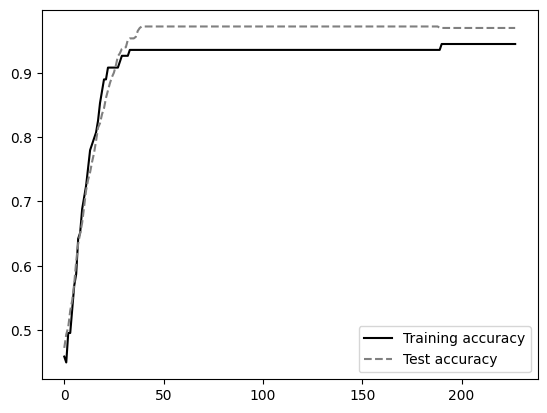

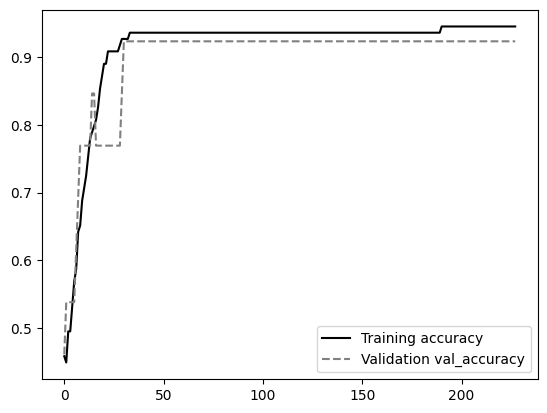

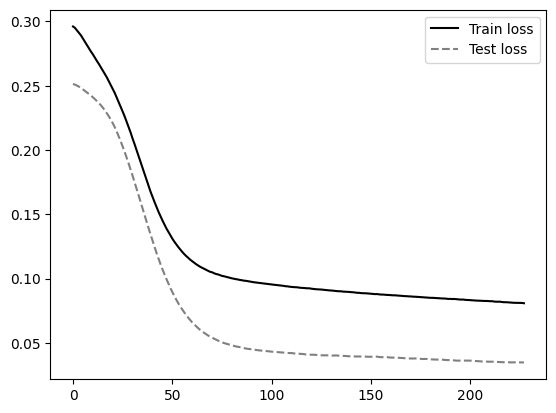

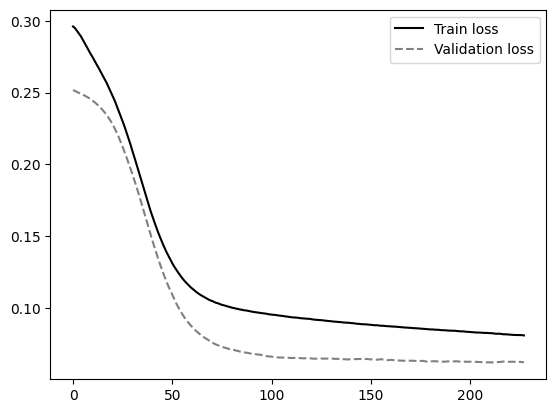

In [107]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
# test_model(model, x_test, y_test)